In [1]:
from striped.job import SinglePointStripedSession as Session, IPythonDisplay

from histbook import Hist, beside, groupby, below
from histbook import bin as hbin

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [2]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [12]:
all_hists = []
cat = groupby("category", keeporder=True)

countsLen = Hist(hbin("countsLen", 100, 0, 100000), cat)
all_hists.append(countsLen)
countsDist = Hist(hbin("countsDist", 10, 0, 10), cat)
all_hists.append(countsDist)
entriesLen = Hist(hbin("entriesLen", 100, 0, 100000), cat)
all_hists.append(entriesLen)

electronPt = Hist(hbin("electronPt", 100, 0, 500), cat)
all_hists.append(electronPt)

zMass = Hist(hbin("zMass", 120, 0, 120), cat)
all_hists.append(zMass)

display = IPythonDisplay(
    below(
        beside(
            countsLen.overlay("category").step("countsLen"),
            countsDist.overlay("category").step("countsDist"),
            entriesLen.overlay("category").step("entriesLen"),
        ),
        beside(
            electronPt.overlay("category").step("electronPt"),
            zMass.overlay("category").step("zMass"),
        ),
    )
)

class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()


In [28]:
#__worker_class__
    

# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import

    
import numpy as np
import awkward

def p4_pt(p4):
    return np.hypot(p4[:,0], p4[:,1])

def p4_minv(p4):
    p4sq = p4**2
    return np.sqrt(p4sq.content[:,3] - np.sum(p4sq.content[:,:3], axis=1))

class Worker(object):
    def __init__(self):
        self.Columns = ["Electron.charge", "Electron.p4", "Electron.tightID"]
        
    def run(self, events, job):        
        ele_id = awkward.JaggedArray.fromcounts(events.Electron.count, events.Electron.tightID)
        ele_p4 = awkward.JaggedArray.fromcounts(events.Electron.count, events.Electron.p4)
        ele_pt = awkward.JaggedArray.fromcounts(events.Electron.count, p4_pt(events.Electron.p4))
        
        good = ele_id == 0
        maxpt_good = ele_pt[good].max()
        maxpt_all = ele_pt.max()
        
        zcands = ele_p4[good].pairs(same=False)
        zmass = p4_minv(zcands["0"] + zcands["1"])
        
        
        # separate fill() calls necessary when array sizes are non-uniform
        job.fill(
            category="all",
            countsLen=len(events.Electron.count),
            countsDist=events.Electron.count,
            entriesLen=len(events.Electron.charge),
        )
        job.fill(
            category="all",
            electronPt=maxpt_all,
        )
        job.fill(
            category="pass",
            electronPt=maxpt_good,
        )
        job.fill(
            category="pass",
            zMass=zmass,
        )


Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8          4.909 M events,   9.277 M events/sec


Total events processed: 4908925 in 0.6 seconds -> 8.031814 million events/second


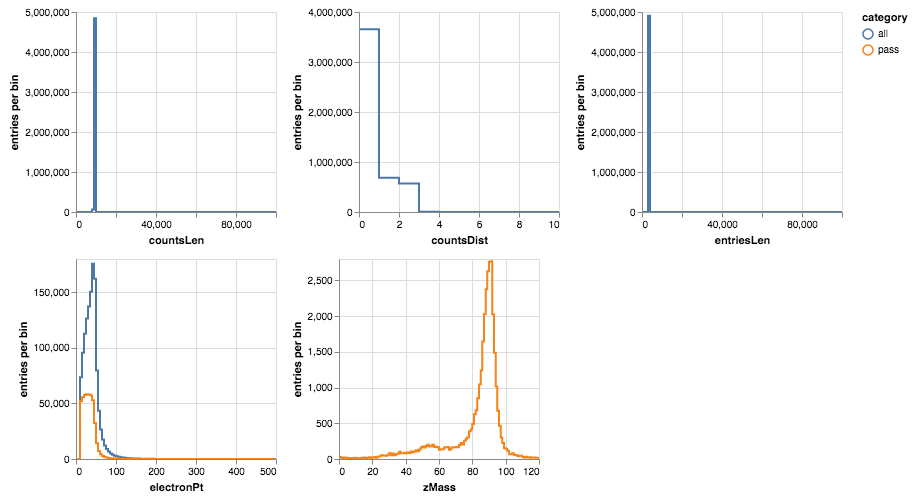

In [29]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists)

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=0.1,
            user_callback=callback, 
            # user_params = {"category":category},
            histograms=all_hists
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)
